# Ada-Boost

This Notebook implements an Ada-Boost with simple decision stumps which are randomly generated. In ascending order, for every feature, a random decision stump is created. Once every feature is split up into two region, we start from the beginning with the first feature again until the defined number of decision stumps is created.

In [1]:
from methods import load_data, test_classification, formatize_weather_data
from Ada_boost import AdaBoost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import csv

## Toy Dataset

We are going to consider the following toy dataset first.

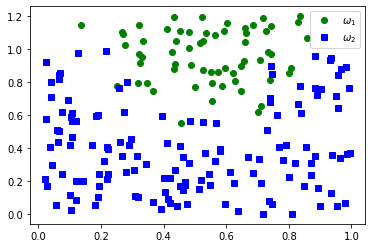

In [2]:
# load_data gives two data sets of two classes
data_1, data_2, test_data = load_data()
fig = plt.figure()
plt.plot(data_1[:, 0], data_1[:, 1], 'go')
plt.plot(data_2[:, 0], data_2[:, 1], 'bs')
plt.legend(['$\omega_1$', '$\omega_2$'])
plt.show()

To see how to create a decision boundary, an example is shown below. The data is split up into two classes at the beginning. This step would however not be necessary, but it simplifies the demonstration.

First, we show how a stump-like decision boundary is trained.

In [3]:
def train_hypothesis(data_1, data_2, sample_weights_1, sample_weights_2, k_stump, s):
    n_1, d = np.shape(data_1)
    n_2, d = np.shape(data_2)

    hyp_1 = []
    hyp_2 = []
    eps = 0
    
    for i in range(n_1):
        if data_1[i, s] >= k_stump:
            hyp_1.append(1)
        else:
            # misclassified
            hyp_1.append(-1)
            eps += sample_weights_1[i]
    
    for i in range(n_2):
        if data_2[i, s] >= k_stump:
            # misclassified
            hyp_2.append(1)
            eps += sample_weights_2[i]
        else:
            hyp_2.append(-1)
            
    return hyp_1, hyp_2, eps

Updating the sample weights is quite easy.

In [5]:
def update_sample_weights(sample_weights_1, sample_weights_2, hyp_1, hyp_2, a):
    
    # forget the y in the formula because for class 1 it's 1, for class 2 it's -1
    sample_weights_1 = np.multiply(sample_weights_1, np.exp(-a*np.array(hyp_1)))
    sample_weights_2 = np.multiply(sample_weights_2, np.exp(a*np.array(hyp_2)))
    
    # normalize
    Z = np.sum(sample_weights_1) + np.sum(sample_weights_2)
    sample_weights_1 /= Z
    sample_weights_2 /= Z
    
    return sample_weights_1, sample_weights_2

We can now use these two methods to train two decision stumps: First, we generate a random stump between the maximal and minimal value of our data, train two hypotheses and calculate $\varepsilon$ using our *train_hypothesis* method, then calculate $\alpha$ and finally update the sample weights using the aboce *update_sample_weights* method.

In [10]:
data = np.append(data_1, data_2, axis=0)
n, d = np.shape(data)

n_1, d = np.shape(data_1)
n_2, d = np.shape(data_2)

sample_weights_1 = [1/n for i in range(n_1)]
sample_weights_2 = [1/n for i in range(n_2)]
bounds = []

# here would be: for i in range(number_of_stumps):
# the following for loop still is correct, with the adaption that d is not necessarily 2:
for s in range(2):
    k_min = np.min(data[:, s])
    k_max = np.max(data[:, s])
    
    # generate a random stump in the range of the values
    k_stump = k_min + (k_max - k_min)*np.random.random()
    
    hyp_1, hyp_2, eps = train_hypothesis(data_1, data_2, sample_weights_1, sample_weights_2, k_stump, s)
            
    # calculate the hypothesis weight a
    a = 1/2*np.log((1-eps)/eps)
    print('Stump number', s)
    print('Stump: ', k_stump)
    print('a = ', a)
    print('eps = ', eps)
    
    # store the stump and the weight
    bounds.append((k_stump, a))
            
    # update sample weights
    sample_weights_1, sample_weights_2 = update_sample_weights(sample_weights_1, sample_weights_2, hyp_1, hyp_2, a)

Stump number 0
Stump:  0.5047395536213967
a =  0.13073985002887786
eps =  0.4350000000000003
Stump number 1
Stump:  1.0882117671124114
a =  0.6810603791228578
eps =  0.20389583969077413


To plot the decision boundary, we also need to implement a classification function. Note that the decision boundary can be a (horizontal or vertical) but not have a 90° angle! For this, we would need at least one additional two-dimensional stump.

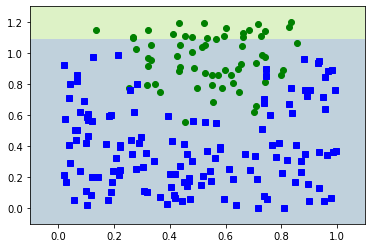

In [11]:
def classify_stump(x):
    f = 0
    for i in range(2):
        k_stump, a = bounds[i]
        if x[i] >= k_stump:
            f += a
        else:
            f -= a
    
    if f >= 0:
        return 1
    else:
        return -1

x = np.linspace(-0.1, 1.1)
y = np.linspace(-0.1, 1.3)
levels = [-1.5, 0.5, 1.5]

xm, ym = np.meshgrid(x, y)
n, m = np.shape(xm)
f = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        f[i, j] = classify_stump(np.array([xm[i, j], ym[i, j]]))

plt.contourf(x, y, f, levels, alpha=0.3)
plt.plot(data_1[:, 0], data_1[:, 1], 'go')
plt.plot(data_2[:, 0], data_2[:, 1], 'bs')
plt.show()

The following Note should be read and understood!

### A Comment on $\alpha$ and $\varepsilon$
$\varepsilon$ indicates the ratio of how many of the (weighted) data samples are classified incorrectly. If the ratio is close to 0, almost every example is classified correctly. This results has a very high hypothesis weight since $\lim\limits_{\varepsilon \to 0} \frac{1}{2}\log \frac{1 - \varepsilon}{\varepsilon} = \infty$. As a consequence, the good hypothesis will dominate the others.

On the contrary, if many examples are misclassified, $\varepsilon$ is close to 1. Therefore, $\frac{1 - \varepsilon}{\varepsilon}$ tends to 0 and $\alpha = \frac{1}{2} \log \frac{1 - \varepsilon}{\varepsilon} \to - \infty$.
Consequently, because $\alpha < 0$, the hypothesis is applied inversely and with a very high weight. This means that also such a hypothesis will dominate the other, and the classification will be good as well.

Finally, if exactly (weighted) half of the examples are misclassified, $\varepsilon = 0.5$ and thus $\alpha = 0$, so this hypotheses is not considered at all.

### Training of the Ada-Boost with the Toy Example
Now we are going to train an Ada-Boost with simple decision stumps. You can enter the number of
decision stumps below. We will then test the classification on the test set.

In [12]:
number_of_stumps = int(input('Enter the number of decision stumps: '))
ada_boost = AdaBoost(data_1, data_2, number_of_stumps)
ada_boost.train()

t_start = time.process_time()
test_classification(ada_boost, test_data)
t_end = time.process_time()
t_ada = t_end - t_start

Enter the number of decision stumps: 100
Ada-Boost Classified  987 out of  1000 examples correctly.
False negative:  6
False positive:  7



Now we are going to plot the decision boundary.

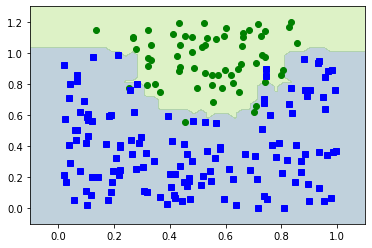

In [13]:
x = np.linspace(-0.1, 1.1)
y = np.linspace(-0.1, 1.3)
levels = [-1.5, 0.5, 1.5]

xm, ym = np.meshgrid(x, y)
n, m = np.shape(xm)
f = np.zeros((n, m))

for i in range(n):
    for j in range(m):
        f[i, j] = ada_boost.classify(np.array([xm[i, j], ym[i, j]]))

plt.contourf(x, y, f, levels, alpha=0.3)
plt.plot(data_1[:, 0], data_1[:, 1], 'go')
plt.plot(data_2[:, 0], data_2[:, 1], 'bs')
plt.show()

Note that the visual result from looking at that decision boundary might differ from the result that the Ada-Boost delivered. These differences can arise if the grid which is used for the plot is too coarse. Taking a finer grid however takes more time to commpute the contour values.

### Not separable data
If the data is more or less separable, the Ada-Boost performs quite well. Non-separable data however are more challenging, but it still performs quite well.

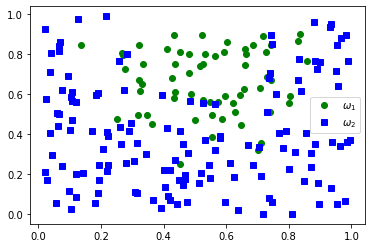

In [14]:
data_1_mod = data_1.copy()
test_data_mod = test_data.copy()

# moving the red dots down
data_1_mod[:, 1] -= 0.3

# also for the test
ind_test = np.where(test_data[:, -1] > 0)[0]
test_data_mod[ind_test, 1] -= 0.3

plt.plot(data_1_mod[:, 0], data_1_mod[:, 1], 'go')
plt.plot(data_2[:, 0], data_2[:, 1], 'bs')
plt.legend(['$\omega_1$', '$\omega_2$'])
plt.show()

In [15]:
number_of_stumps = int(input('Enter the number of stumps: '))
ada_boost_mod = AdaBoost(data_1_mod, data_2, number_of_stumps)
ada_boost_mod.train()

test_classification(ada_boost_mod, test_data_mod)

Enter the number of stumps: 100
Ada-Boost Classified  889 out of  1000 examples correctly.
False negative:  44
False positive:  67



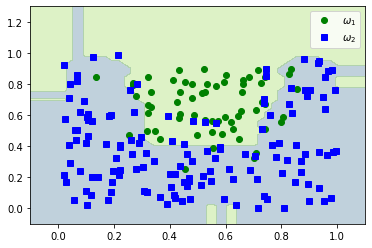

In [16]:
for i in range(n):
    for j in range(m):
        f[i, j] = ada_boost_mod.classify(np.array([xm[i, j], ym[i, j]]))

plt.contourf(x, y, f, levels, alpha=0.3)
plt.plot(data_1_mod[:, 0], data_1_mod[:, 1], 'go')
plt.plot(data_2[:, 0], data_2[:, 1], 'bs')
plt.legend(['$\omega_1$', '$\omega_2$'])
plt.show()

## Australia Weather Dataset

We are using an adapted and shortened dataset on Australian weather prediction, the full version can be downloaded here:

https://togaware.com/the-weatheraus-dataset/

The training data of size 10'000 and test data of size 1'000 were taken randomly out of the full data set of size about 157'000, which shrinks to about 128'000 after removing all unseen data.

We take the input data below and want to predict whether it is going to rain the next day.

Note that the full data set is biased quite heavily. About 78% of all data points share the label 'no rain'. If you want to look at unbiased data, uncomment the two lines below.

In [18]:
reader = csv.reader(open("weatherAUS_training.csv", "rt", encoding="utf8"))
training_data = list(reader)
training_data = np.array(training_data)

reader = csv.reader(open("weatherAUS_test.csv", "rt", encoding="utf8"))
test_data = list(reader)
test_data = np.array(test_data)

data_1, data_2 = formatize_weather_data(training_data)

# for unbiased data: uncomment the next line
# data_2 = data_2[:np.shape(data_1)[0], :]

test_data_1, test_data_2 = formatize_weather_data(test_data)

# for unbiased data: uncomment the next line
# test_data_2 = test_data_2[:np.shape(test_data_1)[0], :]

test_data = np.append(test_data_1, test_data_2, axis=0)

pd.DataFrame(training_data)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainTomorrow
1,8.7,21.7,0,39,17,20,56,35,1025.4,1022.1,14.2,20.4,No
2,8.9,17.2,9.2,69,31,30,81,50,1008,1005,11.6,15.5,Yes
3,10.8,20.8,0,33,11,24,67,54,1027.3,1021.1,15,18.8,No
4,-0.1,10.5,0.2,31,7,11,95,68,1019,1017.2,5,9.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,13,26.8,0,35,6,7,80,47,1015.8,1011.5,18.8,26.5,Yes
9997,10,25.5,0,37,20,11,40,24,1029,1024.7,17.4,24.8,No
9998,17.9,21.4,9.2,43,24,28,86,86,1022.7,1020.3,20,19.7,Yes
9999,14.5,30.5,0,76,13,46,40,27,1008,1004.4,23.2,28.1,No


In [19]:
number_of_stumps = int(input('Enter the number of decision stumps: '))
ada_boost_weather = AdaBoost(data_1, data_2, number_of_stumps)
ada_boost_weather.train()

print('Trained')
print()

test_classification(ada_boost_weather, test_data)

Enter the number of decision stumps: 100
Trained

Ada-Boost Classified  847 out of  1000 examples correctly.
False negative:  97
False positive:  56

